# Chapter 2. Machine Learning with DeepChem

## DeepChem Datasets

In [15]:
import deepchem as dc
import numpy as np

In [6]:
x = np.random.random((4,5))
y = np.random.random((4,1))

In [7]:
x

array([[0.9771539 , 0.72620339, 0.76806508, 0.53038723, 0.29227645],
       [0.91837225, 0.62905541, 0.97431352, 0.20127381, 0.06252816],
       [0.32391407, 0.08762772, 0.74757529, 0.79556935, 0.85623528],
       [0.70101064, 0.03732659, 0.28421014, 0.07101102, 0.87027003]])

In [8]:
y

array([[0.31596328],
       [0.56088928],
       [0.0758669 ],
       [0.28819007]])

Let's now wrap these arrays in a **NumpyDataset** obejct:

In [9]:
dataset = dc.data.NumpyDataset(x,y)

We can also unwrap the **dataset** object to get at the original arrays that we stored insde. 

In [13]:
print(dataset.X)

[[0.9771539  0.72620339 0.76806508 0.53038723 0.29227645]
 [0.91837225 0.62905541 0.97431352 0.20127381 0.06252816]
 [0.32391407 0.08762772 0.74757529 0.79556935 0.85623528]
 [0.70101064 0.03732659 0.28421014 0.07101102 0.87027003]]


In [14]:
print(dataset.y)

[[0.31596328]
 [0.56088928]
 [0.0758669 ]
 [0.28819007]]


In [16]:
np.array_equal(x,dataset.X)

True

In [17]:
np.array_equal(y,dataset.y)

True

## Training a Model to Predict Toxicity of Molecules 

### Step 1. Import packages 

In [18]:
import numpy as np
import deepchem as dc 

### Step 2. Load the associated toxicity datasets for training our model 

In [19]:
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21()

RDKit WARNING: [13:40:58] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [13:40:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:41:10] WARNING: not removing hydrogen atom without neighbors


In [20]:
tox21_tasks

['NR-AR',
 'NR-AR-LBD',
 'NR-AhR',
 'NR-Aromatase',
 'NR-ER',
 'NR-ER-LBD',
 'NR-PPAR-gamma',
 'SR-ARE',
 'SR-ATAD5',
 'SR-HSE',
 'SR-MMP',
 'SR-p53']

In [21]:
len(tox21_tasks)

12


Each of the 12 tasks corresponds with a particular biological experiment. In this case, each of these tasks is for an *enzymatic assay* which measures whether the molecules inteh Tox21 dataset bind with the *biological target* in question. The term **NR-AR** and so on correspond with these targets. In this case, each of these targets is a particular enzyme believed to be linked to toxic responses to potential therapeutic molecules. 

In [22]:
tox21_datasets

(<DiskDataset X.shape: (6264, 1024), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>,
 <DiskDataset X.shape: (783, 1024), y.shape: (783, 12), w.shape: (783, 12), ids: ['N#C[C@@H]1CC(F)(F)CN1C(=O)CNC1CC2CCC(C1)N2c1ncccn1'
  'CN(C)C(=O)NC1(c2ccccc2)CCN(CCC[C@@]2(c3ccc(Cl)c(Cl)c3)CCCN(C(=O)c3ccccc3)C2)CC1'
  'CSc1nnc(C(C)(C)C)c(=O)n1N' ...
  'O=C(O[C@H]1CN2CCC1CC2)N1CCc2ccccc2[C@@H]1c1ccccc1'
  'C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4[C@H]3C(=C)C[C@@]21CC'
  'NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CCN(CCc2ccc3c(c2)CCO3)C1'], task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>,
 <DiskDataset X.shape: (784, 1024), y.shape: (784, 12), w.shape: (784, 12), ids: ['CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O.CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O.c1ccc(CNCCNCc2ccccc2)cc1'
  'CC(C)(c1ccc(Oc2ccc3c(c2)C(=O)OC3=O)cc1)c1ccc(Oc2ccc3c(c2)C(=O)OC3=O)cc1'
  'Cc1cc(C(C)(C)C)c(O)c(C)c1

Let's split up these datasets correctly: 

In [28]:
train_dataset, valid_dataset, test_dataset = tox21_datasets

When dealing with new datasets, it's very useful to start by taking a look at their shapes:

In [25]:
train_dataset.X.shape 
# train_dataset contains contains a total of 6264 sampels, each of which has an associated feature vector of 
# length 1024. 

(6264, 1024)

In [26]:
valid_dataset.X.shape

(783, 1024)

In [27]:
test_dataset.X.shape

(784, 1024)

Let's now take a quick look at the **y vectors**:

In [29]:
np.shape(train_dataset.y)

(6264, 12)

In [30]:
np.shape(valid_dataset.y)

(783, 12)

In [31]:
np.shape(test_dataset.y)

(784, 12)

There are 12 data points, as known as *Labels*, for each sample. 
 * In this particular dataset, the samples correspond to molecules, the task correspond to biochemical assays, and each label is the result of a particular assay on a particualr molecule ---- **Those are what we want to train our model to predict**

### Step 3. Find which labels were actually measured
     we can check the dataset's w field, which records its weights

In [33]:
train_dataset.w.shape

(6264, 12)

In [34]:
np.count_nonzero(train_dataset.w) # This is what we actually measured 

63647

In [36]:
np.count_nonzero(train_dataset.w == 0) # This is missing measurements that we should ignore. 

11521

* Of the 6264 * 12 = 75168 elements in the array of labels, only 63647 were actually mdasured. the other 11521 correspond to missing measurements and should be ignored. 

In [37]:
transformers

**BalancingTransformer:**
        * This class is used to correct for unbalanced data.
        * It adjusts the weights for individual data points so that the total weight assigned to every class is the same. 
        * That way, the loss function has no systematic preference for any one class. The loss can only be decreased by learning to correctly distinguish between classes. 

### Step 4. Train models on datasets 

**In this case, we used a premade model class, dc.models.MultitaskClassifer**

In [38]:
model = dc.models.MultitaskClassifier(n_tasks=12,  #number of tasks
                                      n_features=1024,  #number of input features for each sample
                                      layer_sizes=[1000]) #list that sets the number of fully connected hidden layers in  the network, and the width of each one. 

In [39]:
model.fit(train_dataset, nb_epoch=10)

0.4908459663391113

### Step 5. Evaluate our model 

**dc.metrics.Metric :** provides a general way to specify metrics for models. 

**ROC :** Receiver operating characteristic curve is a convenient way to visualize the trade-off. Becuase the model outputs are continuous numbers not discrete predictions. We pick a threshold value nad predict that a molecule is toxic whenever the output is greater than the threshold. A low threshold will produce many false positives (predicting a safe molecule is actually toxic). A higher threshold will give fewer flase positives but more false negatives (incorrectly predicing that a toxic molecule is safe).

**AUC :** The area under the curve probides an indication of the model's ability to distinguish different classes. 

In [40]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

In [41]:
train_scores = model.evaluate(train_dataset,[metric],transformers)
test_scores = model.evaluate(test_dataset,[metric],transformers)

In [42]:
print(train_scores)
print('\n')
print(test_scores)

{'mean-roc_auc_score': 0.9590139457287452}


{'mean-roc_auc_score': 0.6849063486098489}


#### Notice:
 * Our score on the training set is much better than our score on the test set. This shows the model has been **overfit**.

## Case study: Training an MNIST Model 

**In the previous section, we used a premed model class. In this section, we discuss how to train a convolutional neural network, and we will specify the full deep learning architecture ourselves. :**
        * we will introduce dc.models.TensorGraph class

**Convolutional Neural Network (CNN) :** page 19
  * Developed for use in image processing and computer vision. 
  * Each neuron in the first layer takes input from a small region of the visual field (its *receptive field*). Different neurons are specialized to detect particualr local patterns or features.
  * Cells in the second layer take input form local clusters of cells in the first layer, combinding their signals to detect more complicated patterns over a larger receptive field. 
  * Each layer can be viewd as a new representation of the original image. 

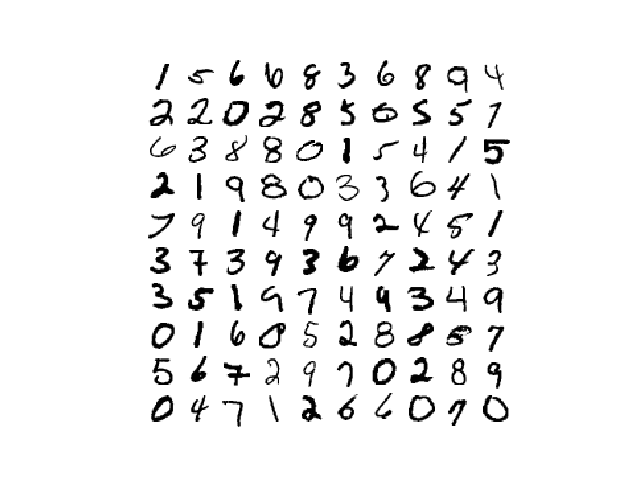

In [1]:
from IPython.display import Image
Image(filename='rmnist_10.png')